In [1]:
import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
import tensorflow as tf
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.regularizers import L2
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') 
tf.config.run_functions_eagerly(True)

In [44]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, classes, aug_per_image, imgs_trans):
    new_images, new_classes = [], []
    for img, y, i in zip(imgs, classes, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
            new_classes.append(y)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images, new_classes

def sensitivity(y_true, y_pred):
    # tp/(fn + tp)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tp = y_true_tmp[y_true_tmp == y_pred_tmp]
    tp = len(tp[tp == 1])
    fn = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fn = len(fn[fn == 0])
    try:
        return tp / (tp + fn)
    except ZeroDivisionError:
        return 0.0

def specificity(y_true, y_pred):
    # tn / (fp + tn)
    y_true_tmp = y_true.numpy()
    y_pred_tmp = np.round(y_pred.numpy())
    tn = y_true_tmp[y_true_tmp == y_pred_tmp]
    tn = len(tn[tn == 0])
    fp = y_pred_tmp[y_true_tmp != y_pred_tmp]
    fp = len(fp[fp == 1])
    try:
        return tn / (tn + fp)
    except ZeroDivisionError:
        return 0.0

def balanced_accuracy(y_true, y_pred):
    # print(np.unique(y_true.numpy()))
    # print(np.unique(np.round(y_pred.numpy())))
    return balanced_accuracy_score(y_true.numpy(), np.round(y_pred.numpy()))

def balanced_acc(y_true, y_pred):
    return (sensitivity(y_true, y_pred) + specificity(y_true, y_pred)) / 2.0

def fit_evaluate(model, X_train, X_test, X_val, y_val, y_train, y_test, batch_size=32, epochs=100):
    res_model = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    scores_model = model.evaluate(X_test, y_test)
    return res_model, scores_model

def graph_history(df, metrics, epochs=100):
    if len(metrics) == 1:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        ax.plot(range(1, epochs+1), df[metrics[0]], 'b-', label='Train')
        ax.plot(range(1, epochs+1), df[f'val_{metrics[0]}'], 'r-', label='Validation')
        ax.set_title(metrics[0])
        ax.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(nrows=1, ncols=len(metrics), sharex=True, figsize=(30, 10))
        for i, metric in zip(range(len(metrics)), metrics):
            ax[i].plot(range(1, epochs+1), df[metric], 'b-', label='Train')
            ax[i].plot(range(1, epochs+1), df[f'val_{metric}'], 'r-', label='Validation')
            ax[i].set_title(metric)
            ax[i].legend()
        plt.show()

In [3]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(N, -1,))
X_tmp = ss.fit_transform(X_tmp)
X = np.reshape(X_tmp, newshape=(N, SIZE_H, SIZE_V))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [4]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (123, 224, 224)
y_train shape (123,)
X_val shape: (31, 224, 224)
y_val shape (31,)
X_test shape: (66, 224, 224)
y_test shape: (66,)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 120)               2

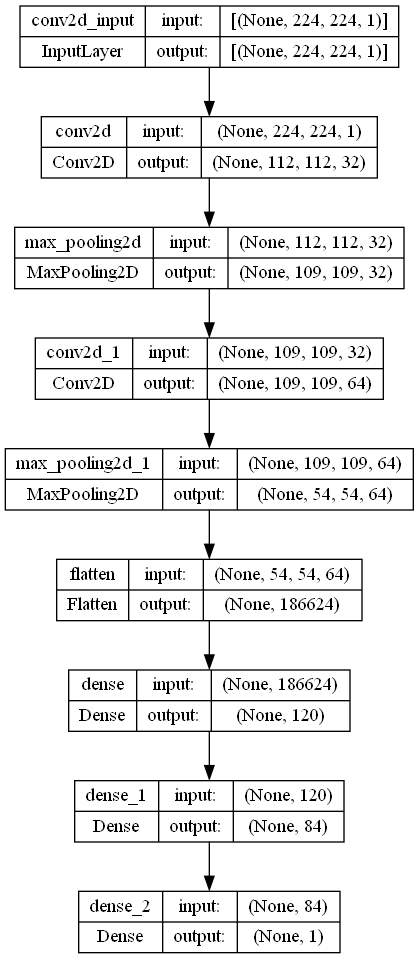

In [5]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

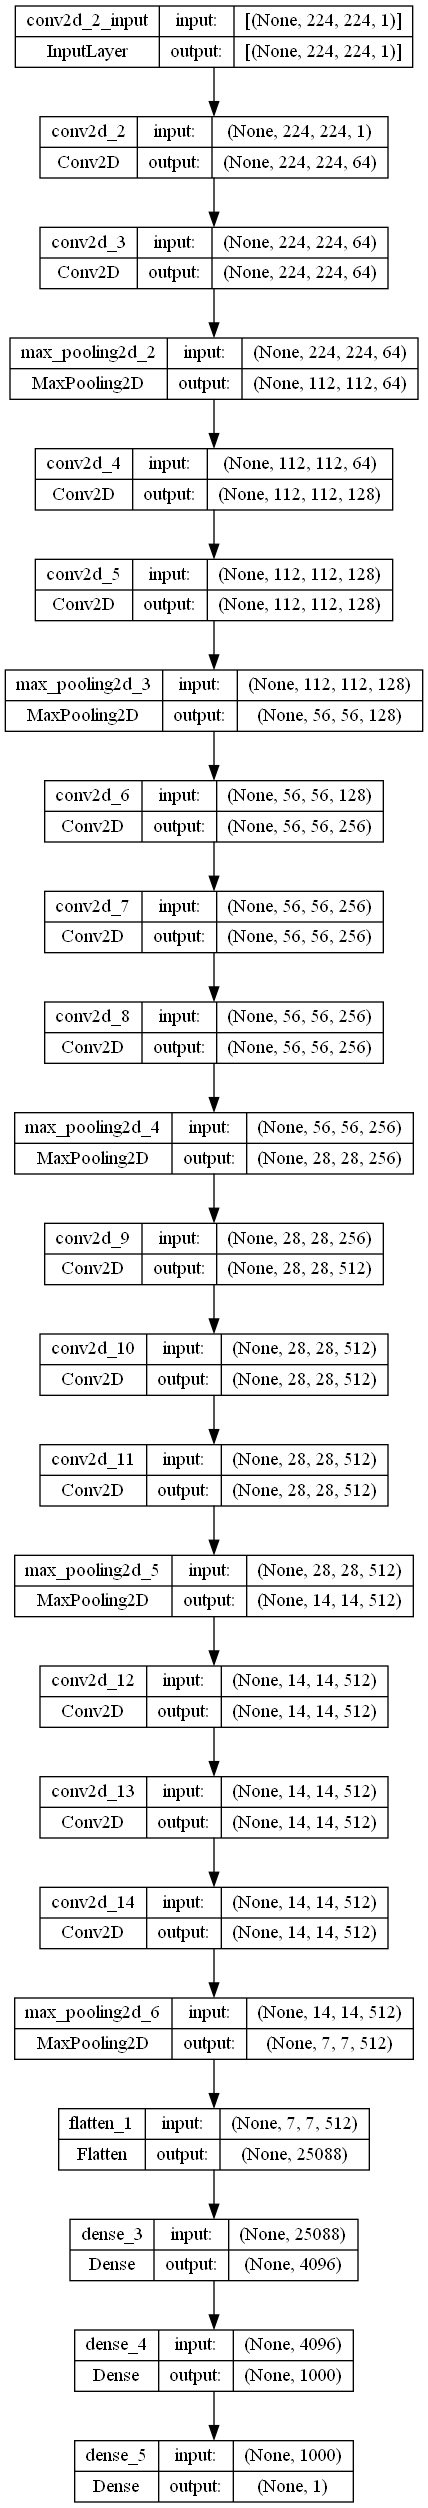

In [6]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=1000, activation='relu'),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_18 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                  

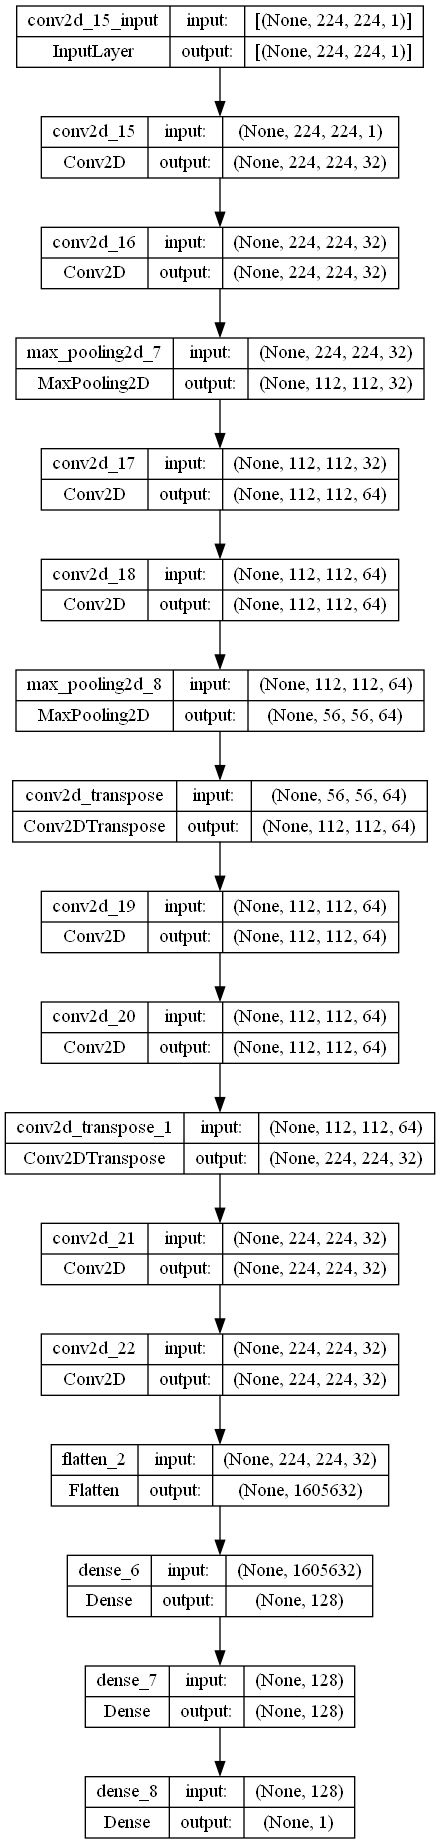

In [7]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dense(units=128, activation='sigmoid'),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net.png', show_shapes=True, show_layer_names=True)

In [8]:
#opt = keras.optimizers.Adam(learning_rate=0.0003)
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [9]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 9s 2s/step - loss: 4.7727 - precision: 0.6667 - binary_accuracy: 0.5122 - recall: 0.4000 - balanced_accuracy: 0.5051 - val_loss: 0.5721 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 0.6441 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6667 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 0.6704 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6545 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 7s 2s/step - loss: 0.6316 - precision: 0.6098 - binary_accuracy: 0.

In [10]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,4.772734,0.666667,0.512195,0.4,0.505066,0.572074,0.612903,0.612903,1.0,0.5
1,0.644143,0.609756,0.609756,1.0,0.500000,0.666676,0.612903,0.612903,1.0,0.5
2,0.670358,0.609756,0.609756,1.0,0.500000,0.654510,0.612903,0.612903,1.0,0.5
3,0.631582,0.609756,0.609756,1.0,0.500000,0.600569,0.612903,0.612903,1.0,0.5
4,0.569857,0.614754,0.617886,1.0,0.508929,0.576919,0.612903,0.612903,1.0,0.5


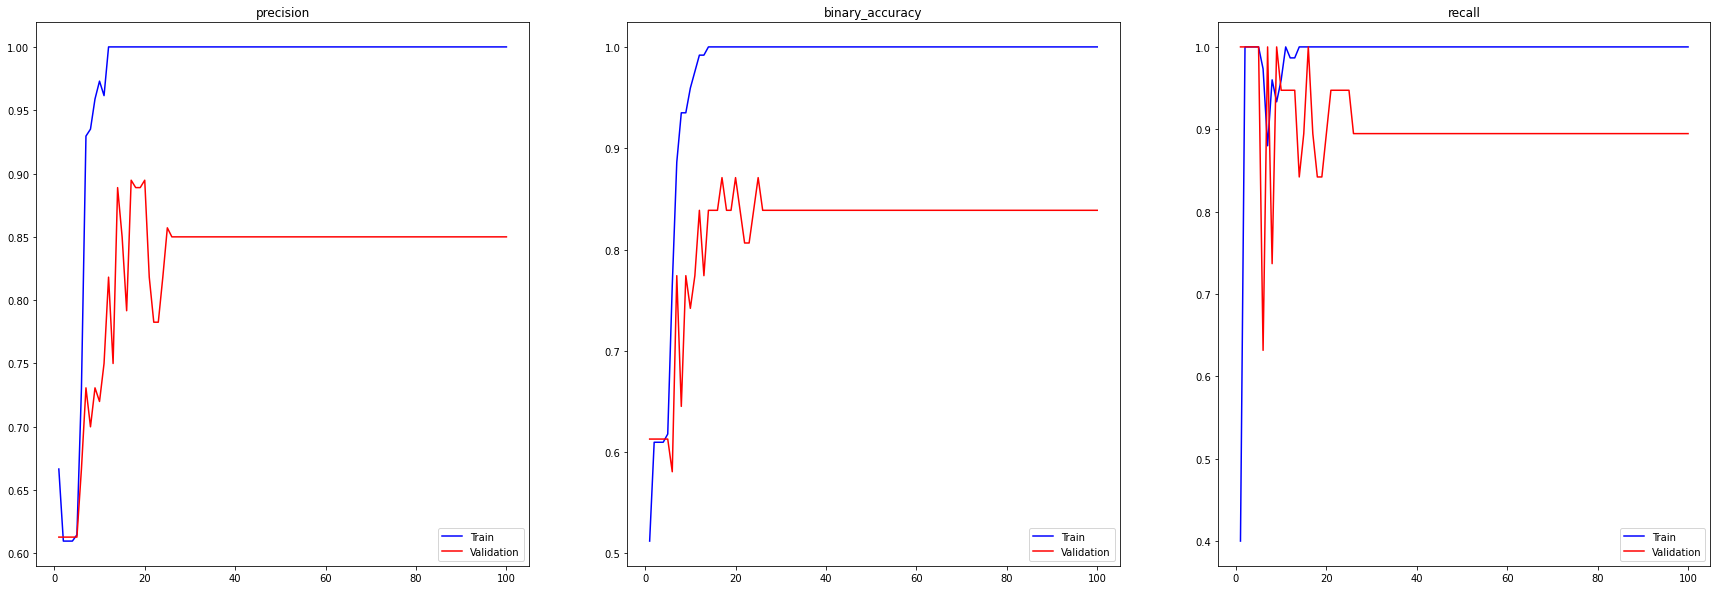

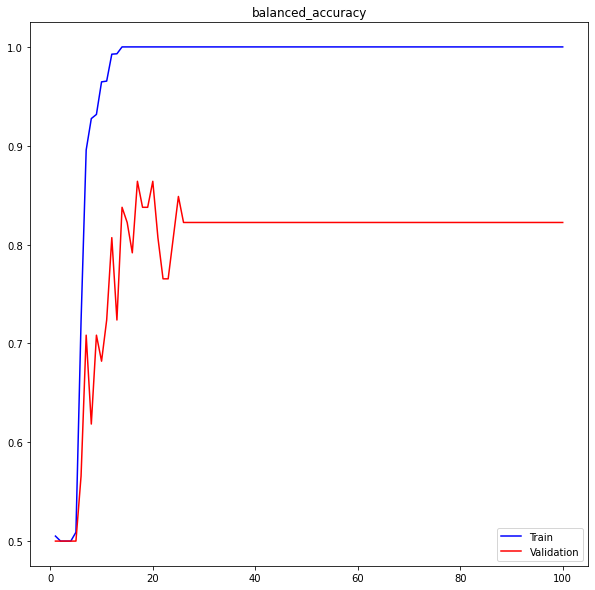

In [11]:
metrics_1, metrics_2 = ['precision', 'binary_accuracy', 'recall'], ['balanced_accuracy']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [12]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 78s 18s/step - loss: 4.4656 - precision: 0.6695 - binary_accuracy: 0.6032 - recall: 0.6870 - balanced_accuracy: 0.5096 - val_loss: 0.6884 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 67s 17s/step - loss: 0.8219 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6872 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 66s 17s/step - loss: 0.6918 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6915 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 66s 17s/step - loss: 0.6908 - precision: 0.6098 - binary_accu

In [13]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,4.465615,0.669492,0.603175,0.686957,0.509615,0.688407,0.612903,0.612903,1.0,0.5
1,0.821950,0.609756,0.609756,1.000000,0.500000,0.687224,0.612903,0.612903,1.0,0.5
2,0.691760,0.609756,0.609756,1.000000,0.500000,0.691540,0.612903,0.612903,1.0,0.5
3,0.690840,0.609756,0.609756,1.000000,0.500000,0.689579,0.612903,0.612903,1.0,0.5
4,0.688804,0.609756,0.609756,1.000000,0.500000,0.685909,0.612903,0.612903,1.0,0.5


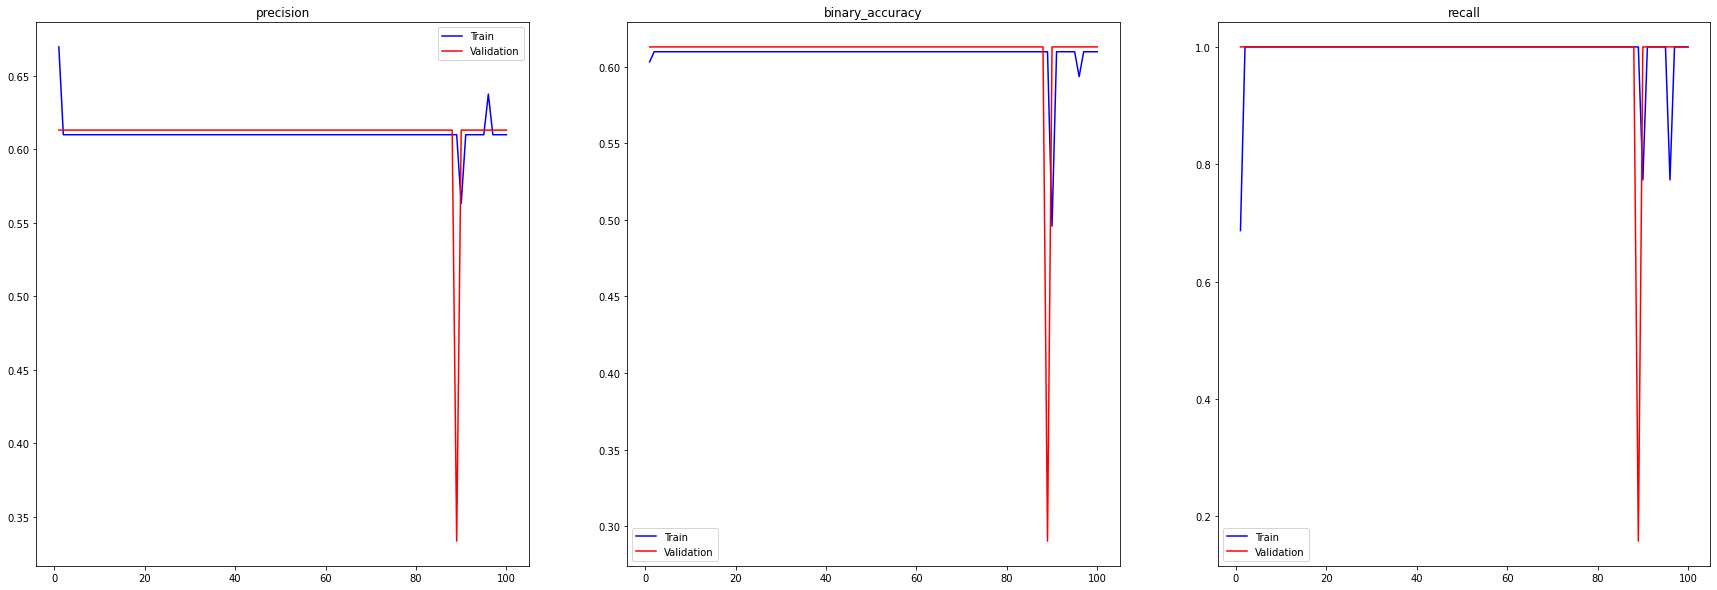

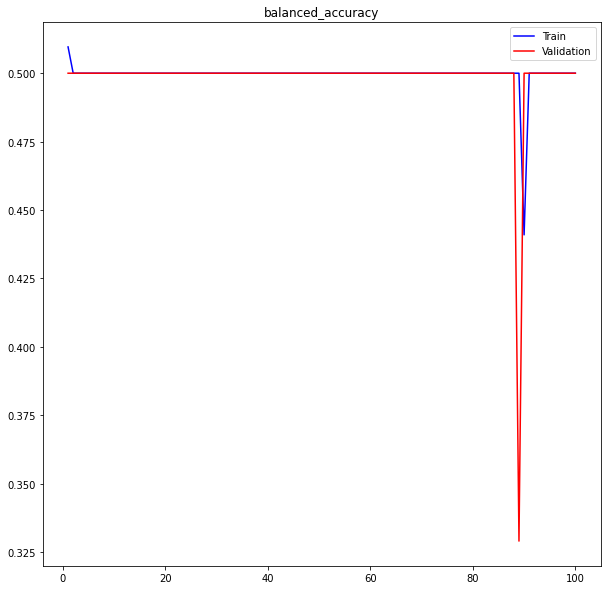

In [14]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [15]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 76s 19s/step - loss: 0.7404 - precision: 0.6242 - binary_accuracy: 0.5979 - recall: 0.8522 - balanced_accuracy: 0.5000 - val_loss: 0.6797 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 57s 14s/step - loss: 0.6903 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6800 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 45s 11s/step - loss: 0.6764 - precision: 0.6098 - binary_accuracy: 0.6098 - recall: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 0.6675 - val_precision: 0.6129 - val_binary_accuracy: 0.6129 - val_recall: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 46s 12s/step - loss: 0.6668 - precision: 0.6098 - binary_accu

In [16]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

,loss,precision,binary_accuracy,recall,balanced_accuracy,val_loss,val_precision,val_binary_accuracy,val_recall,val_balanced_accuracy
0,0.740356,0.624204,0.597884,0.852174,0.5,0.679736,0.612903,0.612903,1.0,0.5
1,0.690291,0.609756,0.609756,1.000000,0.5,0.679996,0.612903,0.612903,1.0,0.5
2,0.676448,0.609756,0.609756,1.000000,0.5,0.667457,0.612903,0.612903,1.0,0.5
3,0.666830,0.609756,0.609756,1.000000,0.5,0.671080,0.612903,0.612903,1.0,0.5
4,0.677187,0.609756,0.609756,1.000000,0.5,0.674854,0.612903,0.612903,1.0,0.5


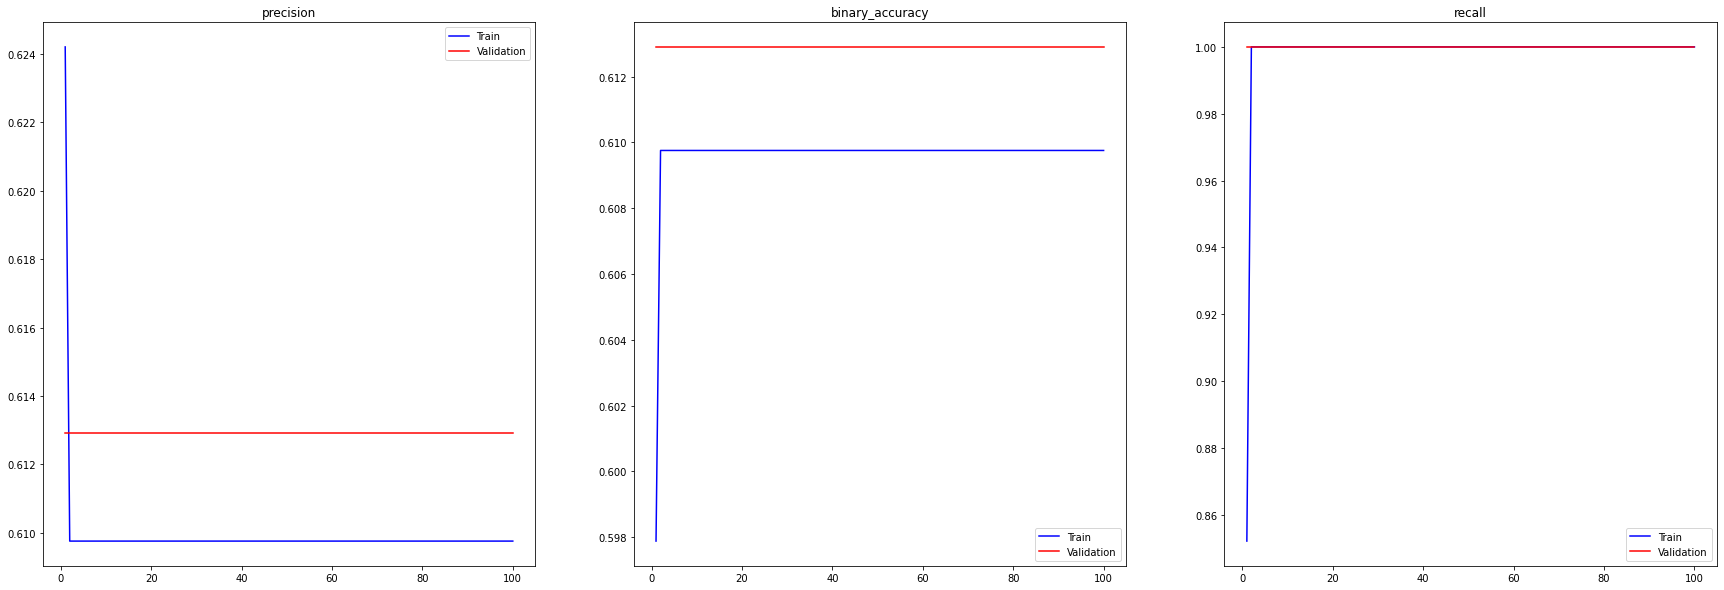

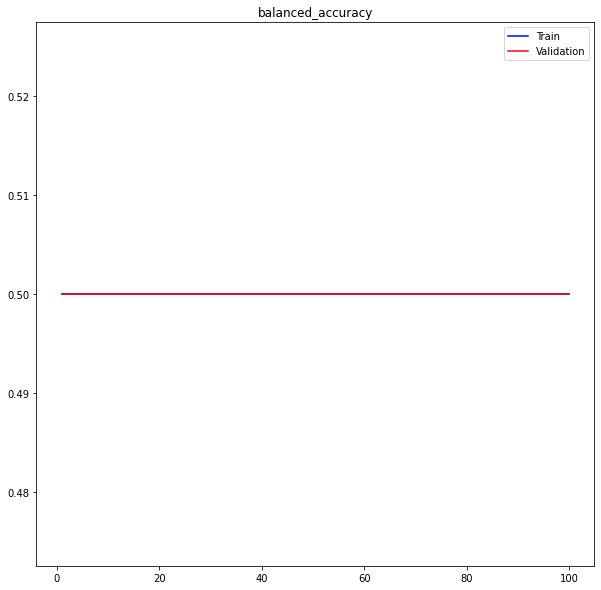

In [17]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [18]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

,Loss,Precision,Binary Accuracy,Recall,Balanced Accuracy
Le-Net 5,2.455740,0.857143,0.696970,0.6,0.658333
VGG-16,0.675125,0.606061,0.606061,1.0,0.333333
Lu-Net,0.670648,0.606061,0.606061,1.0,0.333333


In [19]:
RES_PATH = './results'
scores_df.to_csv(f'{RES_PATH}/test_scores_1.csv')
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_1.csv')
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_1.csv')
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_1.csv')

## DATA AUGMENTATION

In [37]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
# ss = StandardScaler()
# X_tmp = np.reshape(X, newshape=(N, -1,))
# X_tmp = ss.fit_transform(X_tmp)
# X = np.reshape(X_tmp, newshape=(N, SIZE_H, SIZE_V))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [ ]:
# sd = seed(time())
# X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

# print(f'X_train shape: {X_train.shape}')
# print(f'y_train shape {y_train.shape}')
# print(f'X_val shape: {X_val.shape}')
# print(f'y_val shape {y_val.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'y_test shape: {y_test.shape}')

In [38]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-20, 20], p=0.25, border_mode=cv2.BORDER_CONSTANT),
    A.Affine(translate_percent=(-0.05, 0.05))
])

N_AUG = 20
X, y = data_augmentation(X, classes, N_AUG, imgs_trans)
X, y = np.array(X), np.array(y)

ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(N, -1,))
X_tmp = ss.fit_transform(X_tmp)
X = np.reshape(X_tmp, newshape=(N * N_AUG, SIZE_H, SIZE_V))
print(f'X shape: {X.shape}')

# X_train, y_train = data_augmentation(X_train, y_train, N_AUG, imgs_trans)
# X_val, y_val = data_augmentation(X_val, y_val, N_AUG, imgs_trans)
# X_test, y_test = data_augmentation(X_test, y_test, N_AUG, imgs_trans)
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_val, y_val = np.array(X_val), np.array(y_val)
# X_test, y_test = np.array(X_test), np.array(y_test)
# print(f'X_train shape: {X_train.shape}')
# print(f'y_train shape {y_train.shape}')
# print(f'X_val shape: {X_val.shape}')
# print(f'y_val shape {y_val.shape}')
# print(f'X_test shape: {X_test.shape}')
# print(f'y_test shape: {y_test.shape}')

[!] 50 images agumented...
[!] 100 images agumented...
[!] 150 images agumented...
[!] 200 images agumented...
[!] Total of 220 images augmented!

X shape: (4400, 224, 224)


In [39]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=sd, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2464, 224, 224)
y_train shape (2464,)
X_val shape: (616, 224, 224)
y_val shape (616,)
X_test shape: (1320, 224, 224)
y_test shape: (1320,)


In [40]:
EPOCHS_2 = 60
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

Epoch 1/60
77/77 [==============================] - 127s 2s/step - loss: 0.6295 - precision_1: 0.8177 - binary_accuracy: 0.7812 - recall_1: 0.8248 - balanced_accuracy: 0.7686 - val_loss: 0.4354 - val_precision_1: 0.8923 - val_binary_accuracy: 0.8523 - val_recall_1: 0.8613 - val_balanced_accuracy: 0.8594
Epoch 2/60
77/77 [==============================] - 134s 2s/step - loss: 0.4435 - precision_1: 0.8840 - binary_accuracy: 0.8559 - recall_1: 0.8787 - balanced_accuracy: 0.8524 - val_loss: 0.3638 - val_precision_1: 0.8979 - val_binary_accuracy: 0.8847 - val_recall_1: 0.9147 - val_balanced_accuracy: 0.8847
Epoch 3/60
77/77 [==============================] - 129s 2s/step - loss: 0.3576 - precision_1: 0.9127 - binary_accuracy: 0.8937 - recall_1: 0.9127 - balanced_accuracy: 0.8914 - val_loss: 0.3385 - val_precision_1: 0.9380 - val_binary_accuracy: 0.8961 - val_recall_1: 0.8880 - val_balanced_accuracy: 0.9055
Epoch 4/60
77/77 [==============================] - 125s 2s/step - loss: 0.2952 - pre

In [41]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,0.629453,0.817701,0.781250,0.824784,0.768588,0.435352,0.892265,0.852273,0.861333,0.859429
1,0.443546,0.884048,0.855925,0.878748,0.852433,0.363800,0.897906,0.884740,0.914667,0.884734
2,0.357621,0.912725,0.893669,0.912725,0.891362,0.338500,0.938028,0.896104,0.888000,0.905505
3,0.295197,0.933200,0.917208,0.930713,0.912991,0.280715,0.946092,0.928571,0.936000,0.928463
4,0.234270,0.954852,0.938718,0.944037,0.936845,0.262640,0.977012,0.930195,0.906667,0.941955


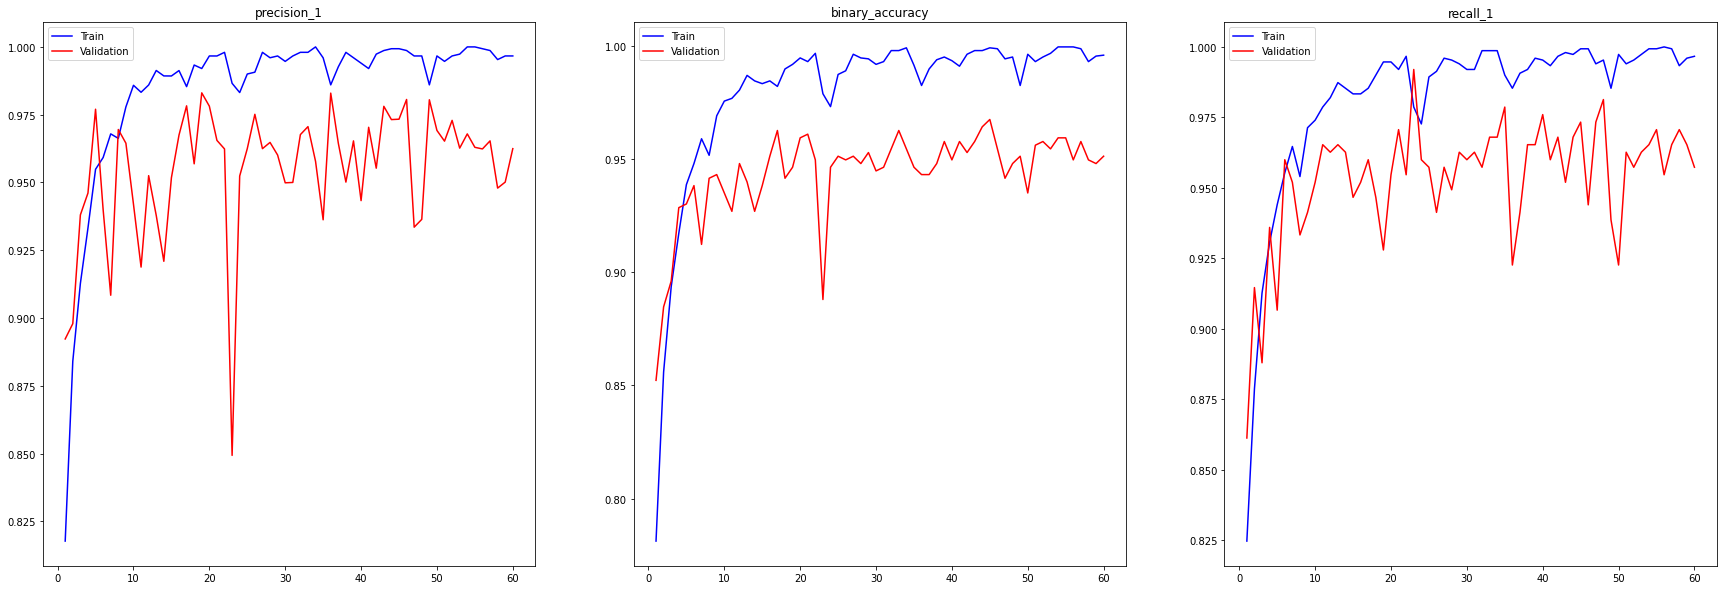

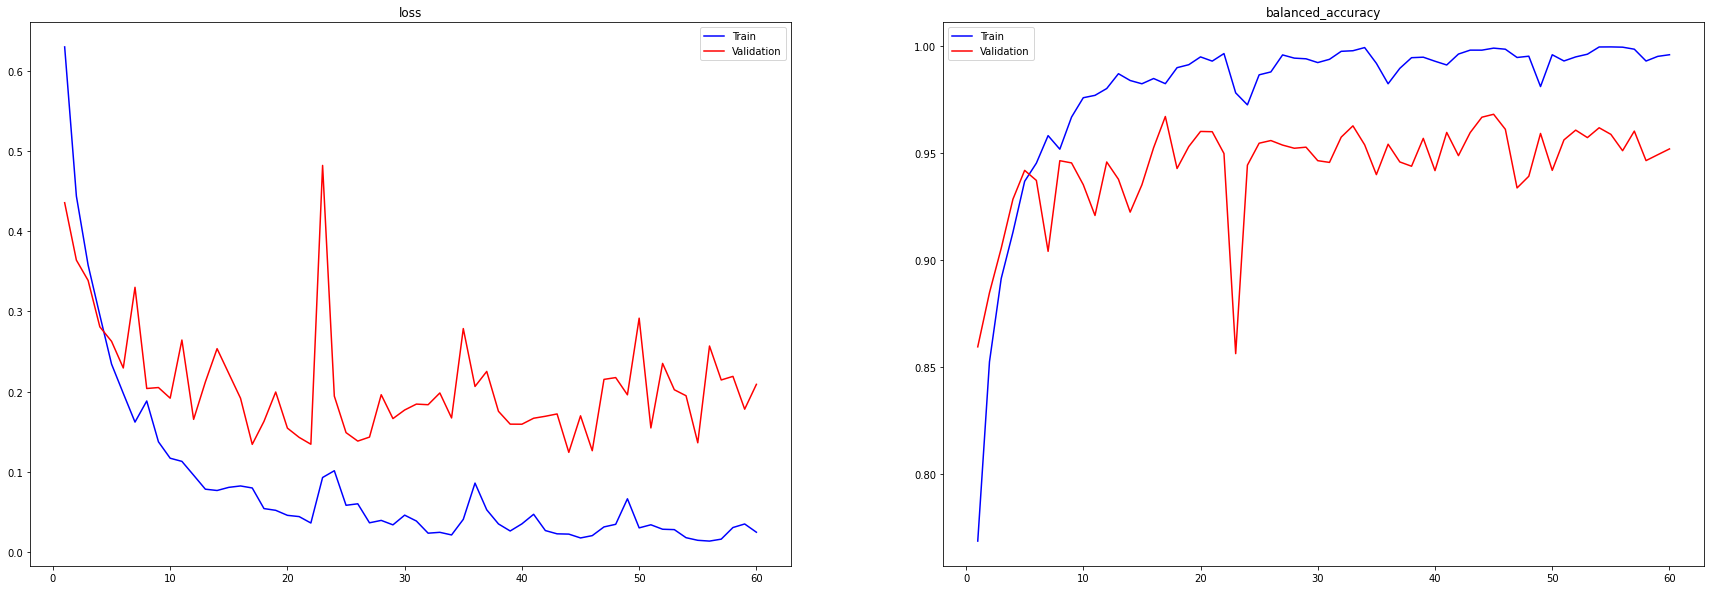

In [45]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['loss', 'balanced_accuracy']
graph_history(df_le_net_5, metrics_1, epochs=EPOCHS_2)
graph_history(df_le_net_5, metrics_2, epochs=EPOCHS_2)

In [47]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_2.csv')

In [ ]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_2.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test, epochs=EPOCHS_2)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_2.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_2.csv')

## CNNs with L-2 regularization and Dropout layers

In [20]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
ss = StandardScaler()
X_tmp = np.reshape(X, newshape=(N, -1,))
X_tmp = ss.fit_transform(X_tmp)
X = np.reshape(X_tmp, newshape=(N, SIZE_H, SIZE_V))
print(f'X shape {X.shape}')
print(f'Num classes: {N_CLASSES}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)
Num classes: 2


In [21]:
sd = seed(time())
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.3, random_state=sd, shuffle=True, stratify=classes)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=sd, shuffle=True, stratify=y_train)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (123, 224, 224)
y_train shape (123,)
X_val shape: (31, 224, 224)
y_val shape (31,)
X_test shape: (66, 224, 224)
y_test shape: (66,)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 109, 109, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 186624)            0         
                                                                 
 dense_9 (Dense)             (None, 120)              

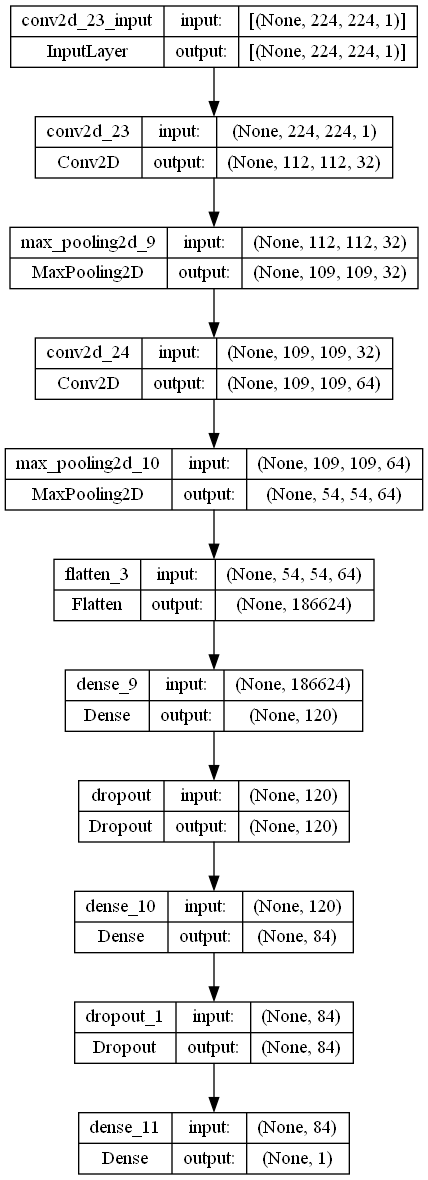

In [22]:
DROPOUT_RATE = 0.3
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(0.01)),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu', kernel_regularizer=L2(0.01)),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=84, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

IMG_PATH = './images'
print(le_net_5.summary())
plot_model(le_net_5, to_file=f'{IMG_PATH}/le_net_5_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

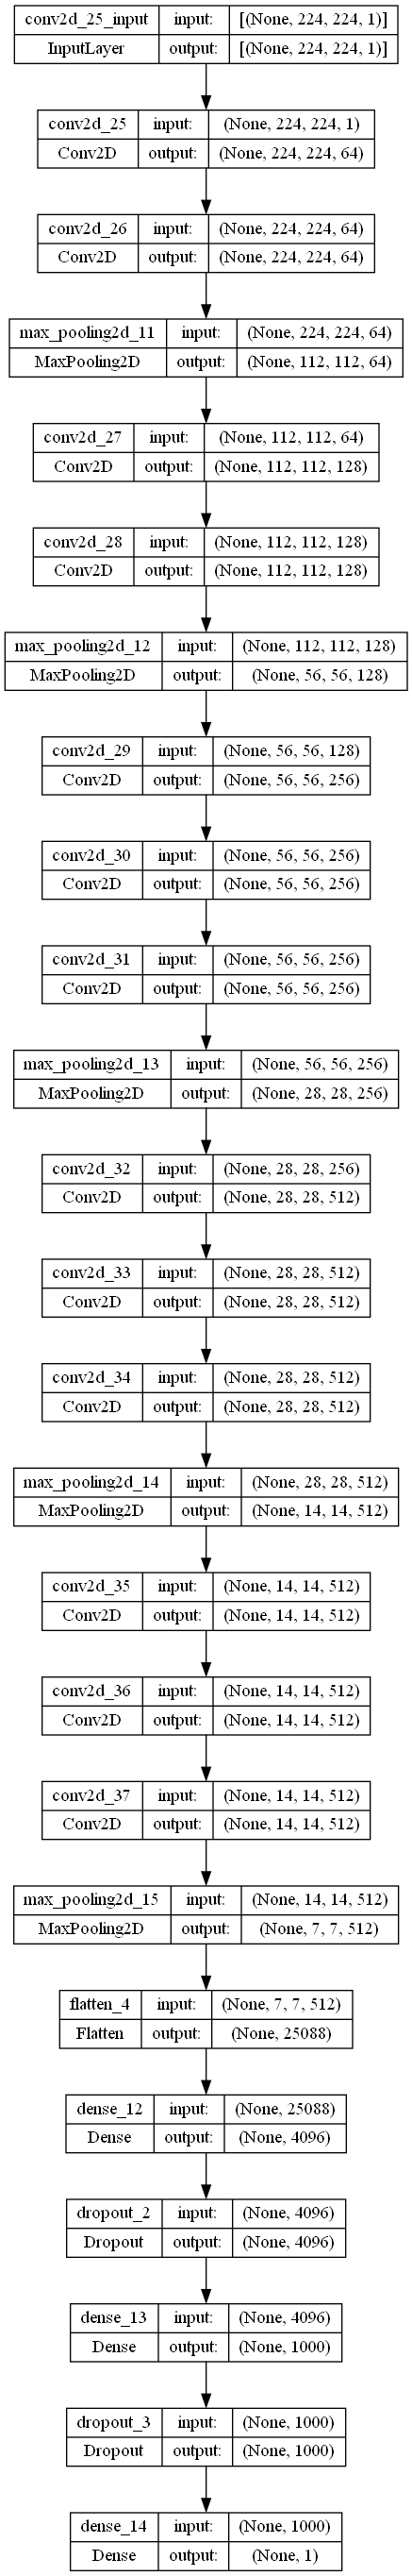

In [23]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    #Dropout(DROPOUT_RATE, seed=sd),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    #Dropout(DROPOUT_RATE, seed=sd),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    #Dropout(DROPOUT_RATE, seed=sd),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    #Dropout(DROPOUT_RATE, seed=sd),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu', kernel_regularizer=L2(0.01)),
    #Dropout(DROPOUT_RATE, seed=sd),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=1000, activation='relu'),
    Dropout(DROPOUT_RATE, seed=sd),
    # OUTPUT LAYER
    Dense(units=1, activation='sigmoid')
])

print(vgg_16.summary())
plot_model(vgg_16, to_file=f'{IMG_PATH}/vgg_16_dropout.png', show_shapes=True, show_layer_names=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_39 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_41 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                 

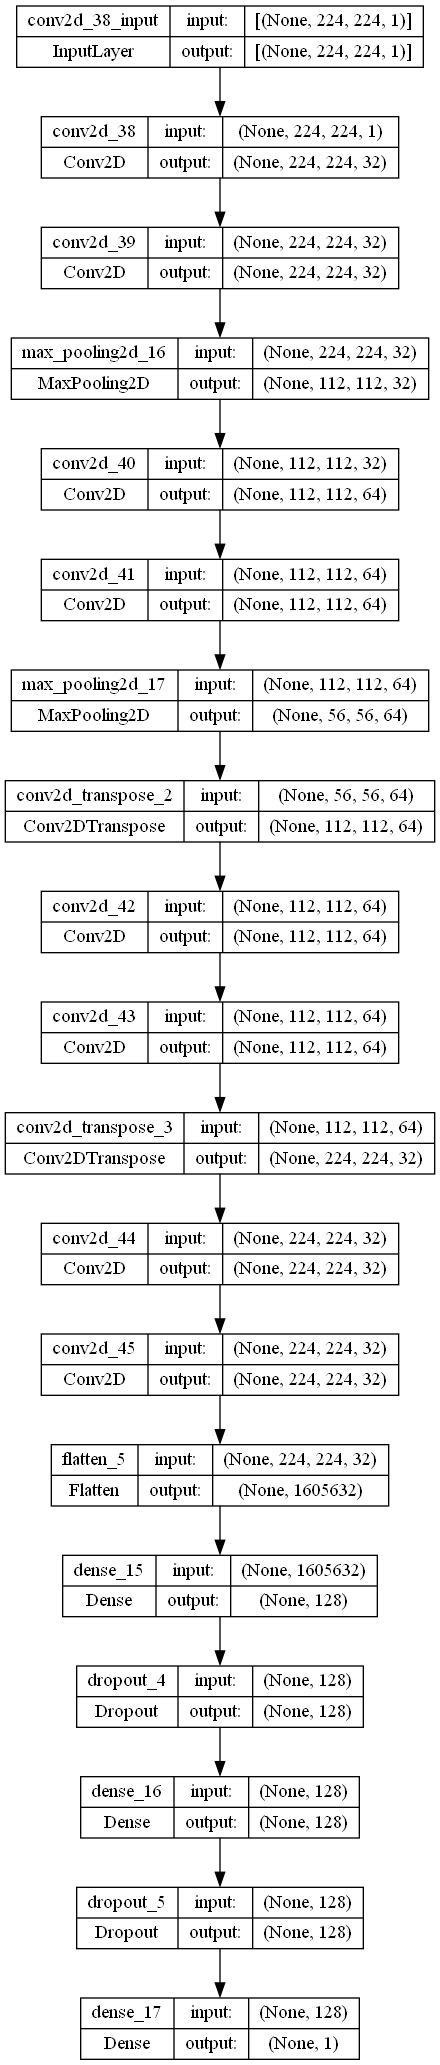

In [24]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    #Dropout(DROPOUT_RATE, seed=sd),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    #Dropout(DROPOUT_RATE, seed=sd),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    #Dropout(DROPOUT_RATE, seed=sd),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu', kernel_regularizer=L2(0.01)),
    #Dropout(DROPOUT_RATE, seed=sd),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dropout(DROPOUT_RATE, seed=sd),
    Dense(units=128, activation='sigmoid'),
    Dropout(DROPOUT_RATE, seed=sd),
    # OUTPUT
    Dense(units=1, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, to_file=f'{IMG_PATH}/lu_net_dropout.png', show_shapes=True, show_layer_names=True)

In [25]:
METRICS = [
    Precision(),
    BinaryAccuracy(),
    Recall(),
    balanced_accuracy
]

le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [26]:
res_le_net, scores_le_net = fit_evaluate(le_net_5, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 11s 3s/step - loss: 4.2712 - precision_1: 0.6957 - binary_accuracy: 0.5366 - recall_1: 0.4267 - balanced_accuracy: 0.5588 - val_loss: 1.1716 - val_precision_1: 0.6333 - val_binary_accuracy: 0.6452 - val_recall_1: 1.0000 - val_balanced_accuracy: 0.5417
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 1.2326 - precision_1: 0.6449 - binary_accuracy: 0.6423 - recall_1: 0.9200 - balanced_accuracy: 0.5282 - val_loss: 1.0834 - val_precision_1: 0.6129 - val_binary_accuracy: 0.6129 - val_recall_1: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 1.0741 - precision_1: 0.6271 - binary_accuracy: 0.6341 - recall_1: 0.9867 - balanced_accuracy: 0.5338 - val_loss: 1.0615 - val_precision_1: 0.6129 - val_binary_accuracy: 0.6129 - val_recall_1: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 1.0526 - precision_1: 0

In [27]:
df_le_net_5 = pd.DataFrame(res_le_net.history)
df_le_net_5.head()

,loss,precision_1,binary_accuracy,recall_1,balanced_accuracy,val_loss,val_precision_1,val_binary_accuracy,val_recall_1,val_balanced_accuracy
0,4.271194,0.695652,0.536585,0.426667,0.558789,1.171574,0.633333,0.645161,1.0,0.541667
1,1.232554,0.644860,0.642276,0.920000,0.528181,1.083404,0.612903,0.612903,1.0,0.500000
2,1.074056,0.627119,0.634146,0.986667,0.533793,1.061532,0.612903,0.612903,1.0,0.500000
3,1.052623,0.625000,0.634146,1.000000,0.526786,1.041122,0.612903,0.612903,1.0,0.500000
4,0.994037,0.625000,0.634146,1.000000,0.537500,1.084861,0.612903,0.612903,1.0,0.500000


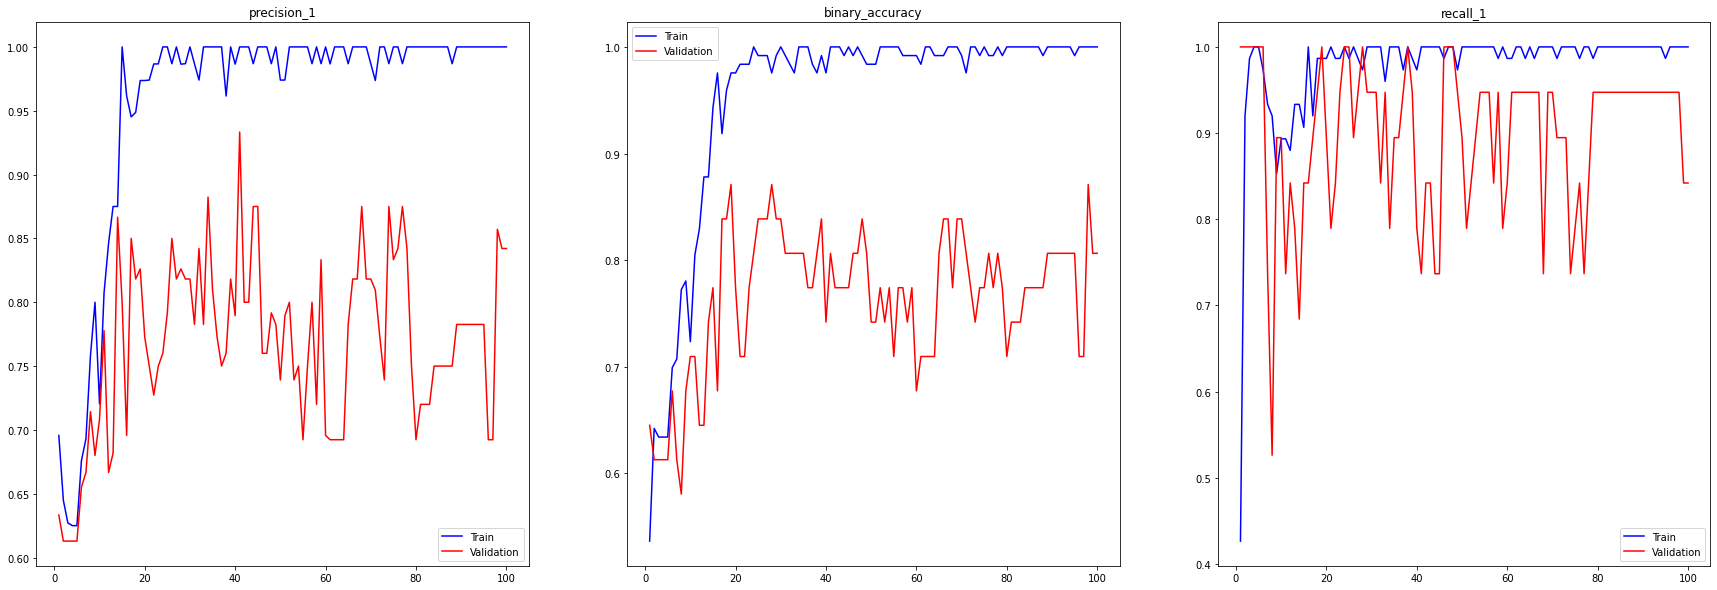

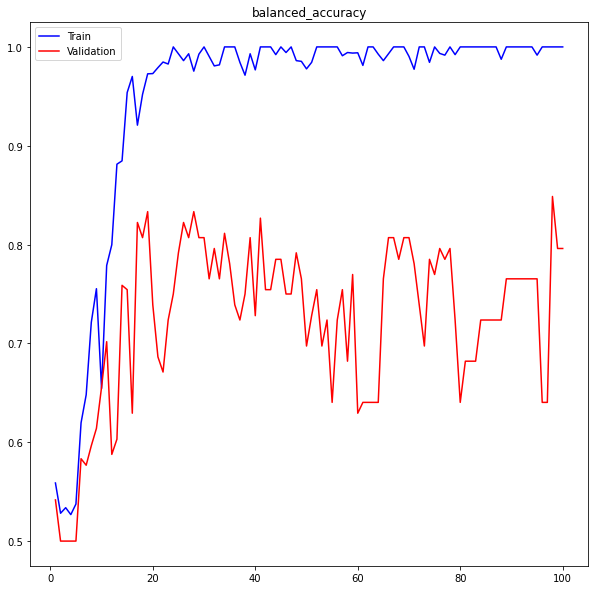

In [29]:
metrics_1, metrics_2 = ['precision_1', 'binary_accuracy', 'recall_1'], ['balanced_accuracy']
graph_history(df_le_net_5, metrics_1)
graph_history(df_le_net_5, metrics_2)

In [30]:
RES_PATH = './results'
df_le_net_5.to_csv(f'{RES_PATH}/le_net_5_metrics_3.csv')

In [31]:
res_vgg_16, scores_vgg_16 = fit_evaluate(vgg_16, X_train, X_test, X_val, y_val, y_train, y_test)

Epoch 1/100
4/4 [==============================] - 80s 18s/step - loss: 34.3283 - precision_1: 0.6639 - binary_accuracy: 0.5979 - recall_1: 0.6870 - balanced_accuracy: 0.4881 - val_loss: 26.9773 - val_precision_1: 0.0000e+00 - val_binary_accuracy: 0.3871 - val_recall_1: 0.0000e+00 - val_balanced_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 60s 15s/step - loss: 23.9066 - precision_1: 0.5968 - binary_accuracy: 0.4878 - recall_1: 0.4933 - balanced_accuracy: 0.5156 - val_loss: 18.9549 - val_precision_1: 0.6129 - val_binary_accuracy: 0.6129 - val_recall_1: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 3/100
4/4 [==============================] - 60s 15s/step - loss: 16.7509 - precision_1: 0.6098 - binary_accuracy: 0.6098 - recall_1: 1.0000 - balanced_accuracy: 0.5000 - val_loss: 13.2520 - val_precision_1: 0.6129 - val_binary_accuracy: 0.6129 - val_recall_1: 1.0000 - val_balanced_accuracy: 0.5000
Epoch 4/100
4/4 [==============================] - 59s 15s/step - loss: 11

KeyboardInterrupt: 

In [ ]:
df_vgg_16 = pd.DataFrame(res_vgg_16.history)
df_vgg_16.head()

In [ ]:
graph_history(df_vgg_16, metrics_1)
graph_history(df_vgg_16, metrics_2)

In [ ]:
df_vgg_16.to_csv(f'{RES_PATH}/vgg_16_metrics_3.csv')

In [ ]:
res_lu_net, scores_lu_net = fit_evaluate(lu_net, X_train, X_test, X_val, y_val, y_train, y_test)

In [ ]:
df_lu_net = pd.DataFrame(res_lu_net.history)
df_lu_net.head()

In [ ]:
graph_history(df_lu_net, metrics_1)
graph_history(df_lu_net, metrics_2)

In [ ]:
df_lu_net.to_csv(f'{RES_PATH}/lu_net_metrics_3.csv')

In [ ]:
scores = [scores_le_net, scores_vgg_16, scores_lu_net]
losses, precisions = [score[0] for score in scores], [score[1] for score in scores]
bin_accs, recalls = [score[2] for score in scores], [score[3] for score in scores]
baccs = [score[4] for score in scores]

scores_df = pd.DataFrame({
    'Loss':losses, 
    'Precision':precisions,
    'Binary Accuracy':bin_accs,
    'Recall':recalls,
    'Balanced Accuracy':baccs
}, index=['Le-Net 5', 'VGG-16', 'Lu-Net'])
scores_df.head()

In [ ]:
scores_df.to_csv(f'{RES_PATH}/test_scores_3.csv')